# ACTIVIDAD 4

## GRUPO 2 - Carlos Gonzalez Van Liempt y Álvaro Farreny Boixader

## Obtención de datos de BTC

In [12]:
"pip install cryptocmd"
"pip install lightgbm"
"pip install skforecast"

'pip install skforecast'

In [8]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import datetime

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')

# Colores Bitcoin
# ==============================================================================
palette_btc = {'naranja': '#f7931a',
               'blanco' : '#ffffff',
               'gris'   : '#4d4d4d',
               'azul'   : '#0d579b',
               'verde'  : '#329239'
              }

# Modelado y Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

In [89]:
# Descarga de datos
from cryptocmd import CmcScraper
scraper = CmcScraper('BTC', '1-1-2015', '27-5-2019')

In [90]:
# Transformar datos recogidos en un dataframe
data = scraper.get_dataframe()
data.sort_values(by='Date', ascending=True, inplace=True)

pd.set_option('display.max_columns', None)
display(data)
pd.reset_option('display.max_columns')

,Date,Open,High,Low,Close,Volume,Market Cap
1607,2015-01-01,320.434998,320.434998,314.002991,314.248993,8.036550e+06,4.297536e+09
1606,2015-01-02,314.079010,315.838989,313.565002,315.032013,7.860650e+06,4.309551e+09
1605,2015-01-03,314.846008,315.149994,281.082001,281.082001,3.305440e+07,3.846270e+09
1604,2015-01-04,281.145996,287.230011,257.612000,264.195007,5.562910e+07,3.616321e+09
1603,2015-01-05,265.084015,278.341003,265.084015,274.473999,4.396280e+07,3.758098e+09
...,...,...,...,...,...,...,...
4,2019-05-23,7677.268834,7943.791390,7533.196693,7881.846721,2.445711e+10,1.396541e+11
3,2019-05-24,7881.695321,8140.719918,7824.448887,7987.371566,2.591913e+10,1.415391e+11
2,2019-05-25,7991.885039,8117.925945,7965.976212,8052.543859,2.225681e+10,1.427082e+11
1,2019-05-26,8055.205919,8687.520799,7924.670191,8673.216035,2.667797e+10,1.537255e+11


In [15]:
# Preparación del dato
# ==============================================================================
data['date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')
data = data.loc[:, ['date', 'Open', 'Close', 'High', 'Low']]
data = data.rename({'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, #RENOMBRAMOS LOS DATOS A MINUSCULAS
                    axis=1)
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()

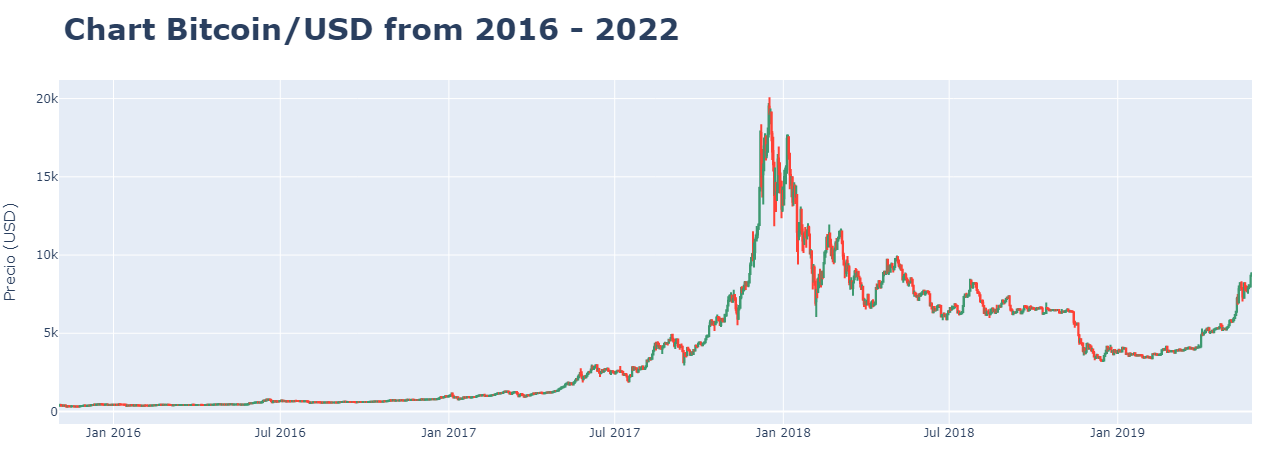

In [16]:
# Gráfico de velas japonesas interactivo con Plotly
# ==============================================================================
candlestick = go.Candlestick(
                    x     = data.index,
                    open  = data.open,
                    close = data.close,
                    low   = data.low,
                    high  = data.high,
                    )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 900,
    height      = 450,
    title       = dict(text='<b>Chart Bitcoin/USD from 2016 - 2022</b>', font=dict(size=30)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20),
    xaxis_rangeslider_visible = False,
)

fig.show()

## (Random Walk)

In [78]:
# Selección fechas train-test
# ==============================================================================
inicio_train = '2016-01-01 00:00:00'
fin_train = '2017-10-30 23:59:59'

print(f"Serie temporal completa : {data.index.min()} --- {data.index.max()}  (n={len(data)})")
print(f"Fechas train            : {data.loc[inicio_train:fin_train].index.min()} --- {data.loc[inicio_train:fin_train].index.max()}  (n={len(data.loc[inicio_train:fin_train])})")
print(f"Fechas test             : {data.loc[fin_train:].index.min()} --- {data.loc[fin_train:].index.max()}  (n={len(data.loc[fin_train:])})")

Serie temporal completa : 2015-11-03 00:00:00 --- 2019-05-27 00:00:00  (n=1302)
Fechas train            : 2016-01-01 00:00:00 --- 2017-10-30 00:00:00  (n=669)
Fechas test             : 2017-10-31 00:00:00 --- 2019-05-27 00:00:00  (n=574)


In [79]:
# Simulación Random Walk
# ==============================================================================
df_rw = data[['close']].copy()
df_rw['pred_close'] = df_rw['close'].shift(1)

# Error de test
# ==============================================================================
y_true = df_rw.loc[fin_train:, 'close']
y_pred = df_rw.loc[fin_train:, 'pred_close']
metrica = mean_absolute_error(y_true, y_pred)

print(f'Error de test: {metrica}')
display(df_rw.loc[fin_train:,].head(4))

Error de test: 248.08458546439238


,close,pred_close
date,,
2017-10-31,6468.399902,6130.529785
2017-11-01,6767.310059,6468.399902
2017-11-02,7078.500000,6767.310059
2017-11-03,7207.759766,7078.500000


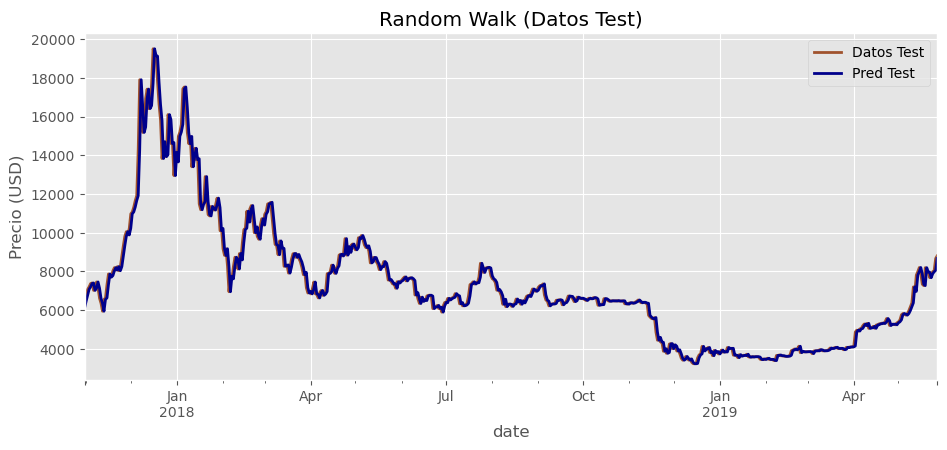

In [80]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
df_rw.loc[fin_train:, 'close'].plot(ax=ax, linewidth=2, label='Datos Test',
                                    c='sienna')
df_rw.loc[fin_train:, 'pred_close'].plot(ax=ax, linewidth=2, label='Pred Test',
                                    c='darkblue')
ax.set_title('Random Walk (Datos Test)')
ax.set_ylabel('Precio (USD)')
ax.legend();

In [81]:
# DataFrame errores test modelos
# ==============================================================================
df_errores = pd.DataFrame({'modelo': 'Base - Random Walk', 'lags': 1, 
                           'error_test': metrica, 'variables_exog': False},
                          index=[0])
df_errores

,modelo,lags,error_test,variables_exog
0,Base - Random Walk,1,248.084585,False


## OTRO TIPO DE ANALISIS
## Forecaster Autorregresivo

In [82]:
# Backtest forecasters con diferentes lags
# ==============================================================================
lags = [1, 7, 30]
metricas = []
predicciones_list = []

for lag in lags:
    
    # Crear forecaster
    forecaster = ForecasterAutoreg(
                    regressor = LGBMRegressor(random_state=123),
                    lags      = lag
                    )
    
    # Backtest test data 1 step
    metrica, predicciones = backtesting_forecaster(
                                 forecaster = forecaster,
                                 y          = data.loc[inicio_train:, 'close'],
                                 initial_train_size = len(data.loc[inicio_train:fin_train, 'close']),
                                 fixed_train_size   = True,
                                 steps      = 1,
                                 refit      = True,
                                 metric     = 'mean_absolute_error',
                                 verbose    = False
                                 )
    
    metricas.append(metrica)
    predicciones_list.append(predicciones)

C:\Users\Usuario\anaconda3\lib\site-packages\skforecast\model_selection\model_selection.py:369: RuntimeWarning:

The forecaster will be fit 574 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 


C:\Users\Usuario\anaconda3\lib\site-packages\skforecast\model_selection\model_selection.py:369: RuntimeWarning:

The forecaster will be fit 574 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 


C:\Users\Usuario\anaconda3\lib\site-packages\skforecast\model_selection\model_selection.py:369: RuntimeWarning:

The forecaster will be fit 574 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




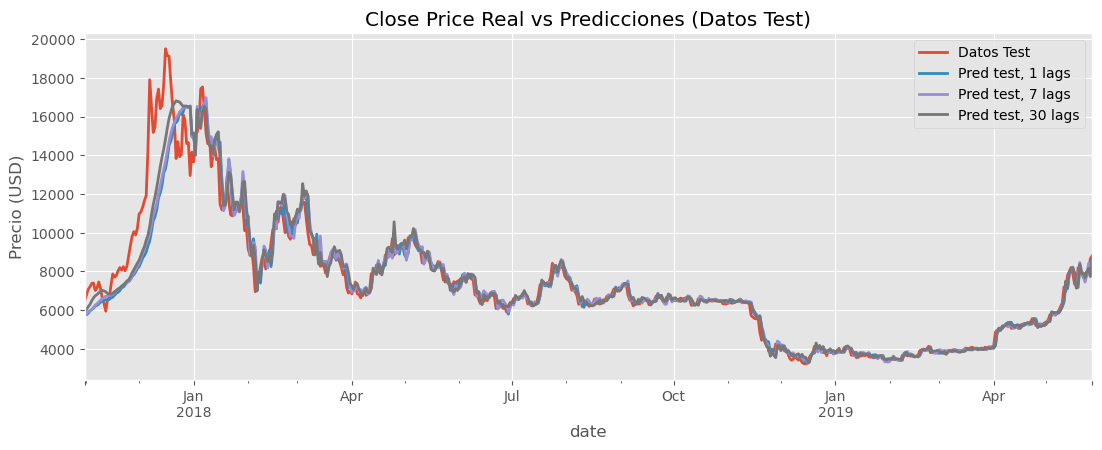

In [83]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(13, 4.5))
data.loc[fin_train:, 'close'].plot(ax=ax, linewidth=2, label='Datos Test')

# Plot predicciones test para diferentes lags
for predicciones, lag in zip(predicciones_list, lags):
    predicciones = predicciones.rename(columns={'pred': f'Pred test, {lag} lags'})
    predicciones.plot(ax=ax, linewidth=2)

ax.set_title('Close Price Real vs Predicciones (Datos Test)')
ax.set_ylabel('Precio (USD)')
ax.legend();

In [84]:
# DataFrame errores de test modelos
# ==============================================================================
modelo = 'LGBMRegressor'

df_errores = pd.concat([
                df_errores,
                pd.DataFrame({'modelo': modelo, 'lags': lags, 
                              'error_test': metricas, 'variables_exog': False})
                ]).reset_index(drop=True)

df_errores.sort_values(by='error_test')

,modelo,lags,error_test,variables_exog
0,Base - Random Walk,1,248.084585,False
3,LGBMRegressor,30,441.872781,False
1,LGBMRegressor,1,456.414158,False
2,LGBMRegressor,7,469.245895,False


Los errores de test (los cuales reflejan cómo de bien generaliza cada modelo) demuestran que ninguno de los modelos mejora el baseline a pesar de que se incorpore más información del pasado (número de lags).

AHORA VAMOS A COMPROBAR SI CON LOS DATOS EXTRAIDOS DE LOS TWEETS PODEMOS COMPROBAR SI EXISTE UNA MEJORA Y UNA PREDICCIÓN DE BTC

## Obtención de datos del CSV

##### Utilizamos Pandas para cargar los datos del archivo .csv que hemos obtenido de kaggle
https://www.kaggle.com/datasets/alaix14/bitcoin-tweets-20160101-to-20190329

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from textblob import TextBlob
import time
import nltk

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [28]:
dfcsv = pd.read_csv('./data/tweetsKaggle.csv',sep=';', nrows=2000000, usecols=['timestamp','user','text'])
dfcsv.head()

,user,timestamp,text
0,KamdemAbdiel,2019-05-27 11:49:14+00,È appena uscito un nuovo video! LES CRYPTOMONN...
1,bitcointe,2019-05-27 11:49:18+00,Cardano: Digitize Currencies; EOS https://t.co...
2,3eyedbran,2019-05-27 11:49:06+00,Another Test tweet that wasn't caught in the s...
3,DetroitCrypto,2019-05-27 11:49:22+00,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,mmursaleen72,2019-05-27 11:49:23+00,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...


## TRATAMIENTO DE DATOS

In [30]:
dfcsv[['Date','Time']] = dfcsv.timestamp.str.split(expand=True)
dfcsv.head()

,user,timestamp,text,Date,Time
0,KamdemAbdiel,2019-05-27 11:49:14+00,È appena uscito un nuovo video! LES CRYPTOMONN...,2019-05-27,11:49:14+00
1,bitcointe,2019-05-27 11:49:18+00,Cardano: Digitize Currencies; EOS https://t.co...,2019-05-27,11:49:18+00
2,3eyedbran,2019-05-27 11:49:06+00,Another Test tweet that wasn't caught in the s...,2019-05-27,11:49:06+00
3,DetroitCrypto,2019-05-27 11:49:22+00,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,2019-05-27,11:49:22+00
4,mmursaleen72,2019-05-27 11:49:23+00,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,2019-05-27,11:49:23+00


In [31]:
dfcsv=dfcsv[['Date','text']]
dfcsv.head()

,Date,text
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONN...
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co...
2,2019-05-27,Another Test tweet that wasn't caught in the s...
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...


In [32]:
print(dfcsv.isnull().sum())
dfcsv = dfcsv.dropna()

Date    0
text    0
dtype: int64


In [34]:
# convertimos la columna "date" a DatetimeIndex
date_index = pd.to_datetime(dfcsv['Date'])
dfcsv = dfcsv.drop('Date', axis=1)
dfcsv['Fecha'] = date_index
dfcsv.drop_duplicates()

,text,Fecha
0,È appena uscito un nuovo video! LES CRYPTOMONN...,2019-05-27
1,Cardano: Digitize Currencies; EOS https://t.co...,2019-05-27
2,Another Test tweet that wasn't caught in the s...,2019-05-27
3,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,2019-05-27
4,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,2019-05-27
...,...,...
1999995,$391.00 at 13:15 UTC [24h Range: $333.78 - $39...,2015-11-03
1999996,#RDD / #BTC on the exchanges: Cryptsy: Error B...,2015-11-03
1999997,#RDD / #BTC on the exchanges: Cryptsy: Error B...,2015-11-03
1999998,"LIVE: Profit = $3,782.84 (8.44 %). BUY B128.71...",2015-11-03


## ANALISIS DE SENTIMIENTOS

In [35]:
#acabar de instalar nltk
#nltk.download("vader_lexicon")

In [167]:
analyzer = SentimentIntensityAnalyzer()
sentimientos = []
for texto in dfcsv['text']:
    sentiment = analyzer.polarity_scores(texto)
    analisis = sentiment['compound']
    sentimientos.append(analisis)
    
dfcsv['sentimientos'] = sentimientos

In [174]:
dfcsv

,text,Fecha,sentimientos
0,È appena uscito un nuovo video! LES CRYPTOMONN...,2019-05-27,0.0000
1,Cardano: Digitize Currencies; EOS https://t.co...,2019-05-27,-0.1027
2,Another Test tweet that wasn't caught in the s...,2019-05-27,0.0000
3,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,2019-05-27,0.0000
4,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,2019-05-27,0.3612
...,...,...,...
1999995,$391.00 at 13:15 UTC [24h Range: $333.78 - $39...,2015-11-03,0.0000
1999996,#RDD / #BTC on the exchanges: Cryptsy: Error B...,2015-11-03,-0.4019
1999997,#RDD / #BTC on the exchanges: Cryptsy: Error B...,2015-11-03,-0.4019
1999998,"LIVE: Profit = $3,782.84 (8.44 %). BUY B128.71...",2015-11-03,0.4404


COSAS QUE HACER:

- juntar el analisis del sentimiento con el dataframe de los valores de bitcoin (de 2016 hasta ahora)
- para ello debemos juntar las fechas del df de btc con el df de sentimientos y concatenarlo
- volver a realizar todo el entrenamiento con los datos del analisis de sentimiento
- ver si la predicción mejora o empeora

opcionales/extras
- averiguar los motivos de los saltos en el analisis de sentimiento, por que es tan alto¿?

In [179]:
dfdiario = dfcsv.groupby(by="Fecha").sum()
dfdiario.columns

Index(['sentimientos'], dtype='object')

In [201]:
#sentimientos ya separados por fechas pero nos faltan 100 fechas que no sabemos cuales son y por eso no nos deja juntarlo con el de btc
tata = dfdiario.loc['01-01-2015':'2019-05-27', 'sentimientos']
tata

Fecha
2015-01-01       84.5157
2015-01-02      114.6192
2015-01-03       99.2108
2015-01-04      113.9221
2015-01-05      118.1233
                 ...    
2019-05-23     8504.0773
2019-05-24    10340.9232
2019-05-25     7339.7204
2019-05-26     7592.3654
2019-05-27     4851.7648
Name: sentimientos, Length: 1562, dtype: float64

In [195]:
# Creamos un índice de fechas con la función date_range()
idx_fechas = pd.date_range(start='2015-01-01', end='2019-05-27')

# Creamos un dataframe vacío con el índice de fechas
fechas = pd.DataFrame(index=idx_fechas)


!!! tenemos ya el dataframe con las fechas de todos los dias, ahora tenemos que juntar los sentimientos con la fecha de cada dia y las fechas que no tengan sentimiento poner un 0 para que podamos juntarlo con el dataframe de btc

## Juntamos datos del analisis con el df de btc

In [202]:
# Transformar datos recogidos en un dataframe
datos = scraper.get_dataframe()
datos.sort_values(by='Date', ascending=True, inplace=True)

pd.set_option('display.max_columns', None)
display(datos)
pd.reset_option('display.max_columns')

,Date,Open,High,Low,Close,Volume,Market Cap
1607,2015-01-01,320.434998,320.434998,314.002991,314.248993,8.036550e+06,4.297536e+09
1606,2015-01-02,314.079010,315.838989,313.565002,315.032013,7.860650e+06,4.309551e+09
1605,2015-01-03,314.846008,315.149994,281.082001,281.082001,3.305440e+07,3.846270e+09
1604,2015-01-04,281.145996,287.230011,257.612000,264.195007,5.562910e+07,3.616321e+09
1603,2015-01-05,265.084015,278.341003,265.084015,274.473999,4.396280e+07,3.758098e+09
...,...,...,...,...,...,...,...
4,2019-05-23,7677.268834,7943.791390,7533.196693,7881.846721,2.445711e+10,1.396541e+11
3,2019-05-24,7881.695321,8140.719918,7824.448887,7987.371566,2.591913e+10,1.415391e+11
2,2019-05-25,7991.885039,8117.925945,7965.976212,8052.543859,2.225681e+10,1.427082e+11
1,2019-05-26,8055.205919,8687.520799,7924.670191,8673.216035,2.667797e+10,1.537255e+11


eliminamos la columna text 

In [13]:
df = df.drop('text', axis=1)
df.head()

,Fecha,sentimientos
0,2019-05-27,0.0000
1,2019-05-27,-0.1027
2,2019-05-27,0.0000
3,2019-05-27,0.0000
4,2019-05-27,0.3612


## Agrupación de df por dia, mes y año

#### Por año

In [14]:
dfanual = df.groupby(pd.Grouper(key='Fecha', freq='1Y')).sum()

In [15]:
print(display(dfanual))

,sentimientos
Fecha,
2009-12-31,0.0000
2010-12-31,0.0000
2011-12-31,3.9768
2012-12-31,592.4937
2013-12-31,17124.7341
2014-12-31,31896.2958
2015-12-31,16369.7524
2016-12-31,53.7069
2017-12-31,114.1558


None


In [20]:
dfgraficoanual = dfanual

<AxesSubplot:title={'center':'Diagrama de Lineas'}, xlabel='Fecha', ylabel='Suma de valores'>

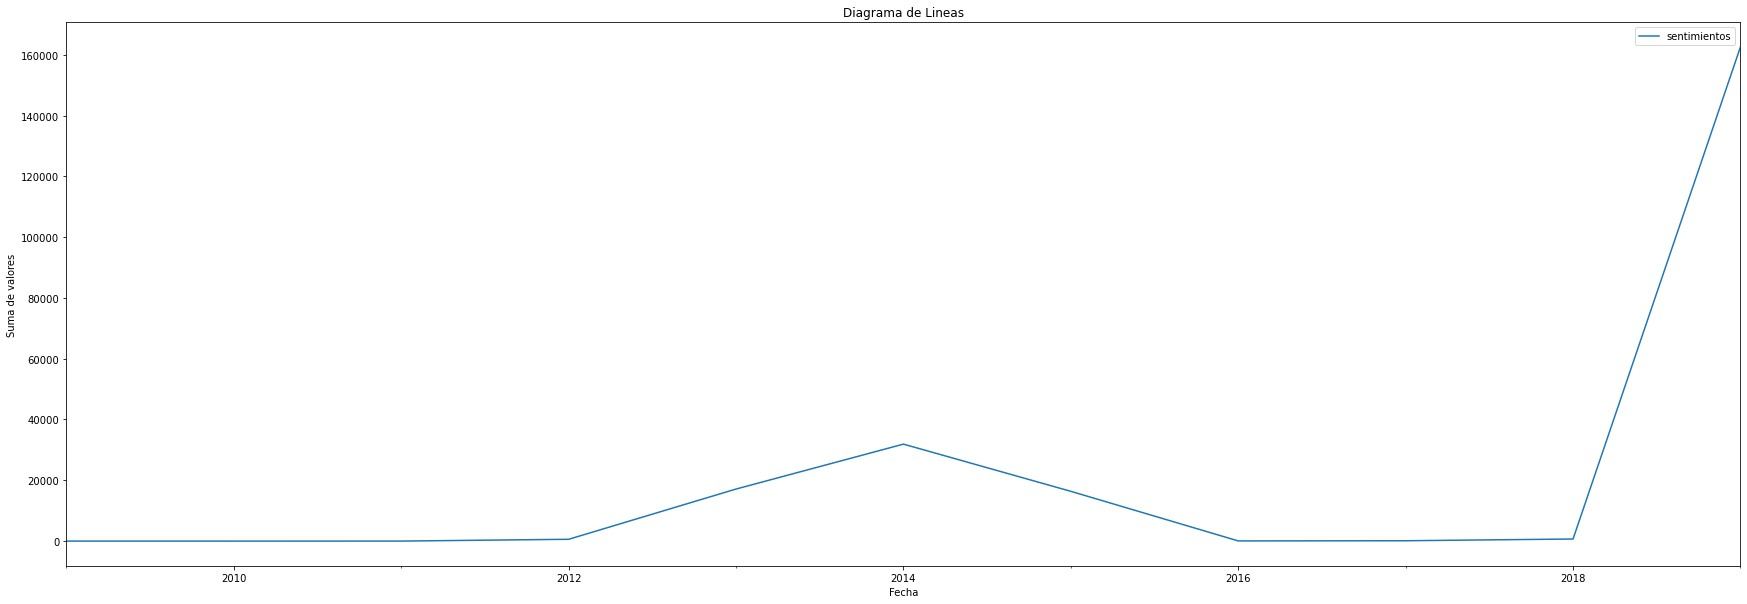

In [25]:
dfgraficoanual.plot(kind='line', title='Diagrama de Lineas', xlabel='Fecha', ylabel='Suma de valores', figsize=(30,10))

<AxesSubplot:title={'center':'Diagrama de Cajas'}, ylabel='Suma de valores'>

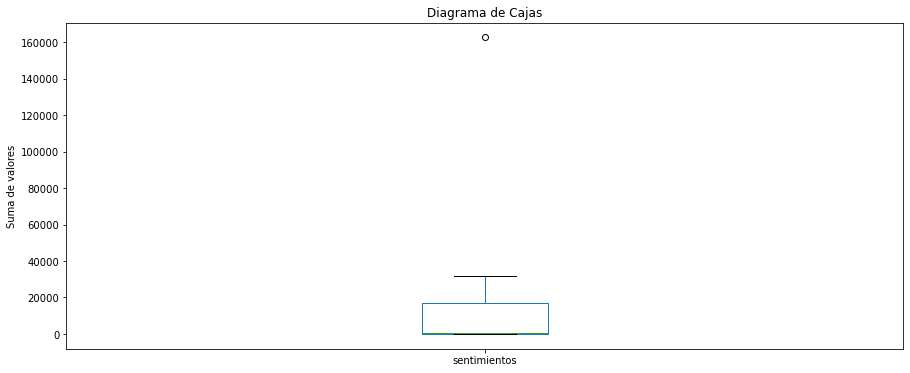

In [26]:
dfgraficoanual.plot(kind='box', title='Diagrama de Cajas', xlabel='Fecha', ylabel='Suma de valores', figsize=(15,6))

#### Por dia

In [28]:
dfdiario = df.groupby(by="Fecha").sum()

In [29]:
print(display(dfdiario))

,sentimientos
Fecha,
2009-01-11,0.0000
2011-01-09,-0.3400
2011-03-27,0.5413
2011-04-14,-0.4215
2011-04-24,0.0000
...,...
2019-05-26,7592.3654
2019-05-27,4851.7648
2019-05-28,32.9951


None


#### Por mes

In [31]:
dfmes = df.groupby(pd.Grouper(key='Fecha', freq='1M')).sum()

In [25]:
display(dfmes)

,sentimientos
Fecha,
2009-01-31,0.0000
2009-02-28,0.0000
2009-03-31,0.0000
2009-04-30,0.0000
2009-05-31,0.0000
...,...
2019-01-31,108.2542
2019-02-28,139.3034
2019-03-31,453.2642


### GRAFICO DIARIO

In [32]:
dfgrafico = dfdiario.clip(upper=500, lower=-500)

<AxesSubplot: title={'center': 'Diagrama de Lineas'}, xlabel='Fecha', ylabel='Suma de valores'>

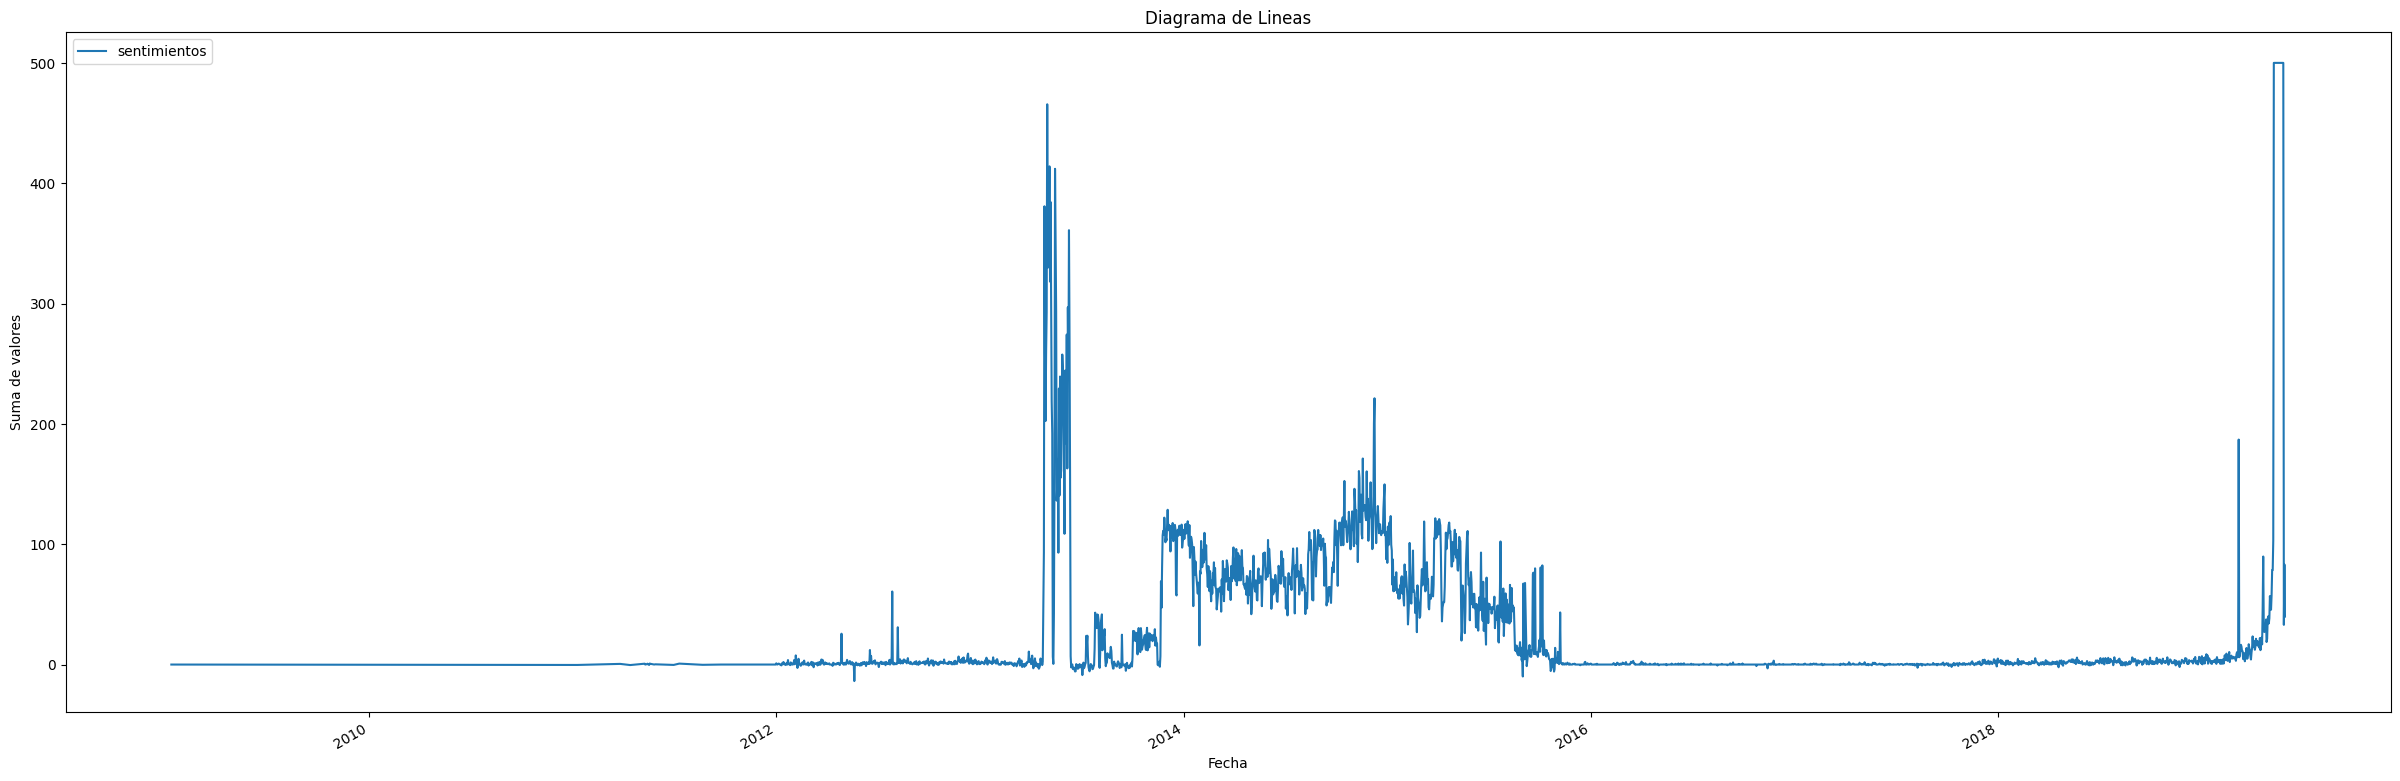

In [26]:
dfgrafico.plot(kind='line', title='Diagrama de Lineas', xlabel='Fecha', ylabel='Suma de valores', figsize=(30,10))

<AxesSubplot:title={'center':'Diagrama de Cajas'}, ylabel='Suma de valores'>

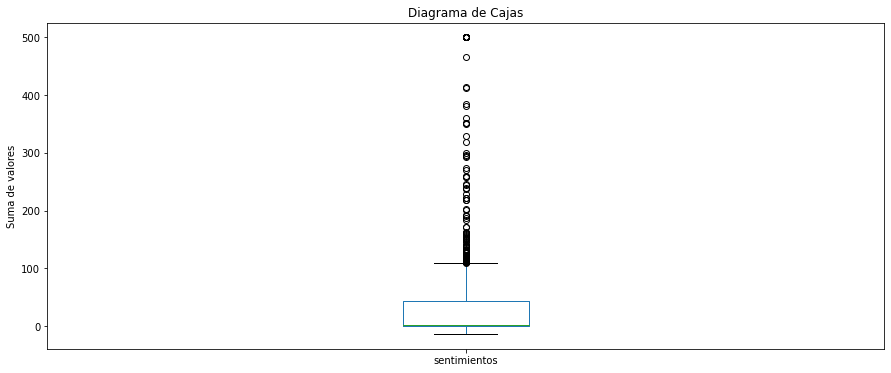

In [34]:
dfgrafico.plot(kind='box', title='Diagrama de Cajas', xlabel='Fecha', ylabel='Suma de valores', figsize=(15,6))

#### GRAFICO POR MES

<AxesSubplot: title={'center': 'Diagrama de Lineas'}, xlabel='Fecha', ylabel='Suma de valores'>

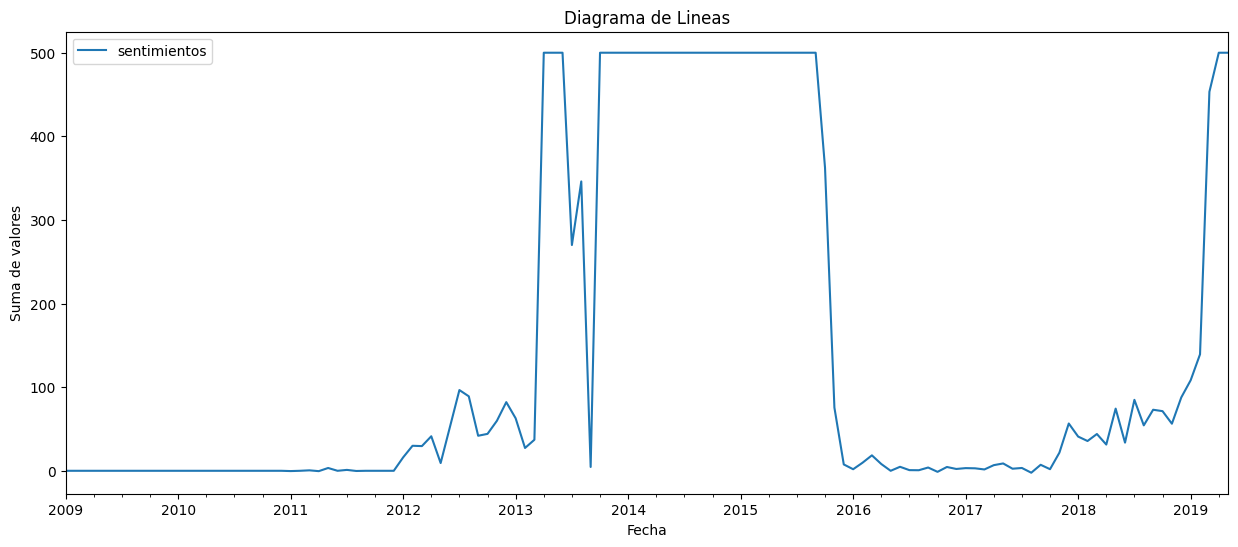

In [ ]:
dfgraficomes = dfmes.clip(upper=500, lower=-500)
dfgraficomes.plot(kind='line', title='Diagrama de Lineas', xlabel='Fecha', ylabel='Suma de valores', figsize=(15,6))

<AxesSubplot: title={'center': 'Diagrama de Cajas'}, xlabel='Fecha', ylabel='Suma de valores'>

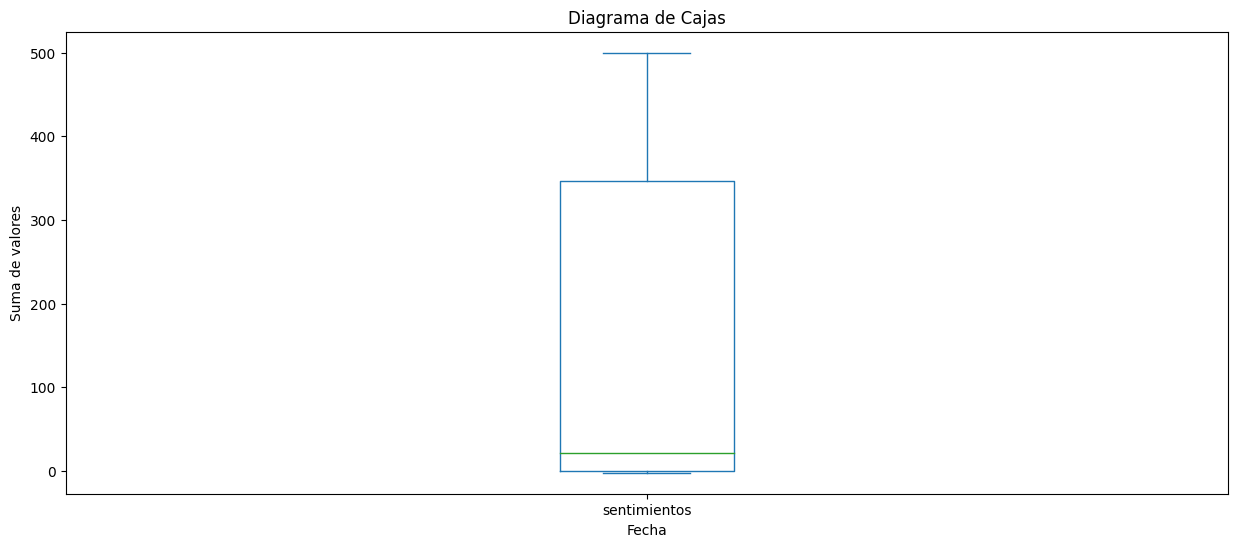

In [ ]:
dfgraficomes.plot(kind='box', title='Diagrama de Cajas', xlabel='Fecha', ylabel='Suma de valores', figsize=(15,6))